In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

from pmdarima.arima import ndiffs
from pmdarima.arima import auto_arima
from datetime import datetime

%matplotlib inline

In [3]:
res = requests.post('http://projects.knmi.nl/klimatologie/daggegevens/getdata_dag.cgi', data='stns=370&vars=TG&start=20150101')
lines = res.text.splitlines()

lines[:25]

['# BRON: KONINKLIJK NEDERLANDS METEOROLOGISCH INSTITUUT (KNMI)',
 '# Opmerking: door stationsverplaatsingen en veranderingen in waarneemmethodieken zijn deze tijdreeksen van dagwaarden mogelijk inhomogeen! Dat betekent dat deze reeks van gemeten waarden niet geschikt is voor trendanalyse. Voor studies naar klimaatverandering verwijzen we naar de gehomogeniseerde reeks maandtemperaturen van De Bilt <http://www.knmi.nl/kennis-en-datacentrum/achtergrond/gehomogeniseerde-reeks-maandtemperaturen-de-bilt> of de Centraal Nederland Temperatuur <http://www.knmi.nl/kennis-en-datacentrum/achtergrond/centraal-nederland-temperatuur-cnt>.',
 '# ',
 '# ',
 '# STN      LON(east)   LAT(north)     ALT(m)  NAME',
 '# 370:         5.377       51.451      22.60  EINDHOVEN',
 '# ',
 '# YYYYMMDD = Date (YYYY=year MM=month DD=day); ',
 '# TG       = Daily mean temperature in (0.1 degrees Celsius); ',
 '# ',
 '# STN,YYYYMMDD,   TG',
 '# ',
 '  370,20150101,   21',
 '  370,20150102,   56',
 '  370,20150103,   

In [3]:
# For every data line, parse the columns to the data -> giving a dictionary [{date, temperature}, {...}]
data = [{
    # First column is the station, which we ignore
    'date': datetime.strptime(line.split(',')[1].strip(), '%Y%m%d'),  # Date is the second column
    'temperature': int(line.split(',')[2].strip()) / 10  # Convert to normal celsius
} for line in lines if not line.startswith('#')]

data[:25]

[{'date': datetime.datetime(2015, 1, 1, 0, 0), 'temperature': 2.1},
 {'date': datetime.datetime(2015, 1, 2, 0, 0), 'temperature': 5.6},
 {'date': datetime.datetime(2015, 1, 3, 0, 0), 'temperature': 2.6},
 {'date': datetime.datetime(2015, 1, 4, 0, 0), 'temperature': 1.8},
 {'date': datetime.datetime(2015, 1, 5, 0, 0), 'temperature': 1.3},
 {'date': datetime.datetime(2015, 1, 6, 0, 0), 'temperature': 1.8},
 {'date': datetime.datetime(2015, 1, 7, 0, 0), 'temperature': 3.8},
 {'date': datetime.datetime(2015, 1, 8, 0, 0), 'temperature': 6.3},
 {'date': datetime.datetime(2015, 1, 9, 0, 0), 'temperature': 9.9},
 {'date': datetime.datetime(2015, 1, 10, 0, 0), 'temperature': 10.0},
 {'date': datetime.datetime(2015, 1, 11, 0, 0), 'temperature': 5.3},
 {'date': datetime.datetime(2015, 1, 12, 0, 0), 'temperature': 8.4},
 {'date': datetime.datetime(2015, 1, 13, 0, 0), 'temperature': 8.6},
 {'date': datetime.datetime(2015, 1, 14, 0, 0), 'temperature': 4.0},
 {'date': datetime.datetime(2015, 1, 15, 0

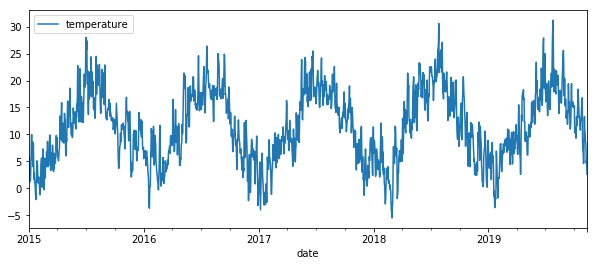

In [4]:
df = pd.DataFrame(data)

df.plot(x='date', y='temperature', figsize=(10, 4))

In [5]:
# Get all the temperatures
y = [p['temperature'] for p in data]

train_len = len(y) - 30
y_train, y_test = y[:train_len], y[train_len:]

train_len, len(y_test)

(1745, 30)

MAE: 4.01 (avg: 10.80 +- 4.09)


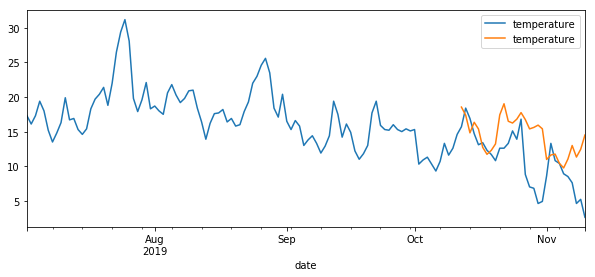

In [21]:
# Create model to make predictions
model = SARIMAX(y_train, order=(0,0,0), seasonal_order=(1,1,1,30), 
                enforce_invertibility=False,
                enforce_stationarity=False)
results = model.fit()

y_pred = results.forecast(len(y_test))

print('MAE: {:.2f} (avg: {:.2f} +- {:.2f})'.format(mean_absolute_error(y_test, y_pred), np.mean(y_test), np.std(y_test)))

df_pred = pd.DataFrame({
    'date': df[-len(y_test):]['date'],
    'temperature': y_pred
})

# Plot the temperature
fig, ax = plt.subplots(figsize=(10, 4))

# Zoom in on last half year
df[df['date'] > datetime(2019, 7, 1)].plot(x='date', ax=ax, label='Actual')
df_pred[df_pred['date'] > datetime(2019, 7, 1)].plot(x='date', ax=ax, label='Predicted')

plt.show()

